In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# Setting Up Test Data

In [2]:
C0 = np.random.rand(5,5)
mu0 = ot.unif(5)

In [3]:
C1 = np.random.rand(4,4)
mu1 = ot.unif(4)

In [4]:
from ot.gromov import gromov_wasserstein as GW

In [5]:
GW(C0,C1,mu0,mu1)

array([[0.13580182, 0.01419818, 0.05      , 0.        ],
       [0.        , 0.2       , 0.        , 0.        ],
       [0.11419818, 0.03580182, 0.        , 0.05      ],
       [0.        , 0.        , 0.        , 0.2       ],
       [0.        , 0.        , 0.2       , 0.        ]])

## Multiscale GW Code

In [16]:
import numpy as np
import ot
from ot.backend import NumpyBackend
from ot.gromov import init_matrix, gwloss, gwggrad, solve_gromov_linesearch
from ot.optim import cg
from ot.bregman import sinkhorn

def gromov_wasserstein_on_sets(
    S1, S2,
    p, q,
    nu1=None, nu2=None,
    loss_fun="square_loss",
    symmetric=None,
    armijo=False,
    # random‐init options
    random_init=False,
    random_seed=None,
    random_init_iter=10,
    # multi‐start option
    multiple_random_inits=1,
    # inner GW‐solver tolerances
    inner_max_iter=1_000,
    inner_tol_rel=1e-9,
    inner_tol_abs=1e-9,
    # outer alternating loop controls
    outer_max_iter=20,
    tol_outer=1e-6,
    ot_method="sinkhorn",
    sinkhorn_reg=1e-3,
    verbose=False
):
    """
    Returns:
      G : (n_s × n_t) coupling
      Q : (n1 × n2) coupling
      cost : float, the final objective
    """
    n1, n2 = len(S1), len(S2)
    n_s, n_t = S1[0].shape[0], S2[0].shape[0]
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    nu1 = np.asarray(nu1) if nu1 is not None else np.ones(n1)/n1
    nu2 = np.asarray(nu2) if nu2 is not None else np.ones(n2)/n2

    # --- multi‐start wrapper ---
    if multiple_random_inits and multiple_random_inits > 1:
        best_obj = np.inf
        best_G, best_Q = None, None

        # precompute gw_data for cost evaluation
        npb = NumpyBackend()
        gw_data = {
            (k,l): init_matrix(S1[k], S2[l], p, q, loss_fun, npb)
            for k in range(n1) for l in range(n2)
        }

        for run in range(multiple_random_inits):
            seed_i = (random_seed + run) if random_seed is not None else None
            G_i, Q_i, _ = gromov_wasserstein_on_sets(
                S1, S2, p, q,
                nu1=nu1, nu2=nu2,
                loss_fun=loss_fun,
                symmetric=symmetric,
                armijo=armijo,
                random_init=True,
                random_seed=seed_i,
                random_init_iter=random_init_iter,
                multiple_random_inits=1,
                inner_max_iter=inner_max_iter,
                inner_tol_rel=inner_tol_rel,
                inner_tol_abs=inner_tol_abs,
                outer_max_iter=outer_max_iter,
                tol_outer=tol_outer,
                ot_method=ot_method,
                sinkhorn_reg=sinkhorn_reg,
                verbose=False,
            )
            # compute cost_i
            A = np.zeros((n1, n2))
            for (k,l), (constC, hC1, hC2) in gw_data.items():
                A[k,l] = gwloss(constC, hC1, hC2, G_i, npb)
            cost_i = np.sum(A * Q_i)

            if cost_i < best_obj:
                best_obj, best_G, best_Q = cost_i, G_i.copy(), Q_i.copy()

        if verbose:
            print(f"Best cost over {multiple_random_inits} inits: {best_obj:.3e}")
        return best_G, best_Q, best_obj

    # --- single solve ---
    # initialize G
    if random_init:
        rng = np.random.default_rng(random_seed)
        R = rng.random((n_s, n_t))
        for _ in range(random_init_iter):
            R *= (p / R.sum(axis=1))[:, None]
            R *= (q / R.sum(axis=0))[None, :]
        G = R
    else:
        G = np.outer(p, q)

    # initialize Q
    Q = np.outer(nu1, nu2)

    # symmetry test
    if symmetric is None:
        sym1 = all(np.allclose(C, C.T, atol=1e-10) for C in S1)
        sym2 = all(np.allclose(C, C.T, atol=1e-10) for C in S2)
        symmetric_flag = sym1 and sym2
    else:
        symmetric_flag = symmetric

    npb = NumpyBackend()

    # precompute init_matrix
    gw_data   = {}
    gw_data_T = {}
    for k in range(n1):
        for l in range(n2):
            constC, hC1, hC2 = init_matrix(S1[k], S2[l], p, q, loss_fun, npb)
            gw_data[(k,l)] = (constC, hC1, hC2)
            if not symmetric_flag:
                Ct, hC1t, hC2t = init_matrix(S1[k].T, S2[l].T, p, q, loss_fun, npb)
                gw_data_T[(k,l)] = (Ct, hC1t, hC2t)

    def make_ls(h1, h2):
        if armijo:
            from ot.gromov import line_search_armijo
            return lambda cost, G_, dG, Mi, cG, dG_: \
                   line_search_armijo(cost, G_, dG, Mi, cG, nx=npb)
        else:
            return lambda cost, G_, dG, Mi, cG, dG_: \
                   solve_gromov_linesearch(
                       G_, dG, cG, h1, h2, M=0.0, reg=1.0, nx=npb,
                       symmetric=symmetric_flag
                   )

    # outer loop
    for it in range(outer_max_iter):
        # aggregate
        constC_agg = np.zeros_like(gw_data[(0,0)][0])
        hC1_agg    = np.zeros_like(gw_data[(0,0)][1])
        hC2_agg    = np.zeros_like(gw_data[(0,0)][2])
        if not symmetric_flag:
            Ct_agg   = np.zeros_like(gw_data_T[(0,0)][0])
            hC1t_agg = np.zeros_like(gw_data_T[(0,0)][1])
            hC2t_agg = np.zeros_like(gw_data_T[(0,0)][2])

        for k in range(n1):
            for l in range(n2):
                w = Q[k,l]
                cC, h1, h2 = gw_data[(k,l)]
                constC_agg += w * cC
                hC1_agg    += w * h1
                hC2_agg    += w * h2
                if not symmetric_flag:
                    cCt, h1t, h2t = gw_data_T[(k,l)]
                    Ct_agg     += w * cCt
                    hC1t_agg   += w * h1t
                    hC2t_agg   += w * h2t

        def f_agg(Gm): return gwloss(constC_agg, hC1_agg, hC2_agg, Gm, npb)
        if symmetric_flag:
            def df_agg(Gm): return gwggrad(constC_agg, hC1_agg, hC2_agg, Gm, npb)
        else:
            def df_agg(Gm):
                g1 = gwggrad(constC_agg,  hC1_agg,  hC2_agg,  Gm, npb)
                g2 = gwggrad(Ct_agg,       hC1t_agg, hC2t_agg, Gm, npb)
                return 0.5*(g1 + g2)

        ls = make_ls(hC1_agg, hC2_agg)
        G_prev = G.copy()
        G = cg(
            p, q,
            0.0, 1.0,
            f_agg, df_agg,
            G_prev,
            line_search=ls,
            log=False,
            numItermax=inner_max_iter,
            stopThr=inner_tol_rel,
            stopThr2=inner_tol_abs
        )

        # update Q
        A = np.zeros((n1, n2))
        for k in range(n1):
            for l in range(n2):
                cC, h1, h2 = gw_data[(k,l)]
                A[k,l] = gwloss(cC, h1, h2, G, npb)

        Q_prev = Q.copy()
        if ot_method == "sinkhorn":
            Q = sinkhorn(nu1, nu2, A, reg=sinkhorn_reg)
        else:
            Q = ot.emd(nu1, nu2, A)

        # convergence
        if verbose:
            obj = np.sum(A * Q)
            print(f"[outer {it+1}] ΔG={np.linalg.norm(G-G_prev):.2e}, ΔQ={np.linalg.norm(Q-Q_prev):.2e}, obj={obj:.3e}")
        if np.linalg.norm(G-G_prev) < tol_outer and np.linalg.norm(Q-Q_prev) < tol_outer:
            break

    # final cost
    A_final = np.zeros((n1, n2))
    for k in range(n1):
        for l in range(n2):
            cC, h1, h2 = gw_data[(k,l)]
            A_final[k,l] = gwloss(cC, h1, h2, G, npb)
    cost = float(np.sum(A_final * Q))

    return G, Q, cost


Version of (standard) GW with multiple initializations.

In [17]:
import numpy as np
import warnings
from ot.backend import get_backend, NumpyBackend
from ot.utils import list_to_array, unif
from ot.gromov import init_matrix, gwloss, gwggrad, solve_gromov_linesearch
from ot.optim import cg

def gromov_wasserstein(
    C1,
    C2,
    p=None,
    q=None,
    loss_fun="square_loss",
    symmetric=None,
    log=False,
    armijo=False,
    # — new random-init args —
    random_init=False,
    random_seed=None,
    random_init_iter=10,
    multiple_random_inits=1,
    # — original args —
    G0=None,
    max_iter=1e4,
    tol_rel=1e-9,
    tol_abs=1e-9,
    **kwargs,
):
    r"""
    (Docstring as before, plus:)

    random_init : bool
        If True, initialize the coupling with a random matrix then IPF‐project to (p,q).
    random_seed : int or None
        Seed for the random initialization.
    random_init_iter : int
        Number of IPF iterations when random_init=True.
    multiple_random_inits : int
        If >1, run that many independent solves (each with its own random init)
        and return the coupling with the lowest final GW loss.
    """
    # 1) Backend & marginals setup (unchanged)
    arr = [C1, C2]
    if p is not None:
        arr.append(list_to_array(p))
    else:
        p = unif(C1.shape[0], type_as=C1)
    if q is not None:
        arr.append(list_to_array(q))
    else:
        q = unif(C2.shape[0], type_as=C1)
    if G0 is not None:
        arr.append(G0)

    nx = get_backend(*arr)
    p0, q0, C10, C20 = p, q, C1, C2

    # Convert to NumPy for the solver
    p_np = nx.to_numpy(p0)
    q_np = nx.to_numpy(q0)
    C1_np = nx.to_numpy(C10)
    C2_np = nx.to_numpy(C20)

    # 2) Symmetry test
    if symmetric is None:
        symmetric_flag = (
            np.allclose(C1_np, C1_np.T, atol=1e-10)
            and np.allclose(C2_np, C2_np.T, atol=1e-10)
        )
    else:
        symmetric_flag = bool(symmetric)

    # 3) Precompute GW ingredients
    npb = NumpyBackend()
    constC, hC1, hC2 = init_matrix(C1_np, C2_np, p_np, q_np, loss_fun, npb)
    if not symmetric_flag:
        constCt, hC1t, hC2t = init_matrix(
            C1_np.T, C2_np.T, p_np, q_np, loss_fun, npb
        )

    # 4) Define loss & gradient
    def f_np(G):
        return gwloss(constC, hC1, hC2, G, npb)

    if symmetric_flag:
        def df_np(G):
            return gwggrad(constC, hC1, hC2, G, npb)
    else:
        def df_np(G):
            g1 = gwggrad(constC,  hC1,   hC2,   G, npb)
            g2 = gwggrad(constCt,   hC1t,  hC2t,  G, npb)
            return 0.5 * (g1 + g2)

    # 5) Line‐search builder
    if armijo:
        from ot.gromov import line_search_armijo
        def make_ls():
            return lambda f, G, dG, M_i, cG, dG_: \
                line_search_armijo(f, G, dG, M_i, cG, nx=npb)
    else:
        def make_ls():
            return lambda f, G, dG, M_i, cG, dG_: \
                solve_gromov_linesearch(
                    G, dG, cG, hC1, hC2,
                    M=0.0, reg=1.0, nx=npb,
                    symmetric=symmetric_flag,
                    **kwargs
                )

    # 6) Helper to IPF‐project a random matrix to (p,q)
    def random_coupling(seed):
        rng = np.random.default_rng(seed)
        R = rng.random((p_np.size, q_np.size))
        for _ in range(random_init_iter):
            R *= (p_np / R.sum(axis=1))[:, None]
            R *= (q_np / R.sum(axis=0))[None, :]
        return R

    # 7) Core GW‐solve given an initial G0_np
    def solve_GW(G0_np, return_log):
        ls = make_ls()
        if return_log:
            res_np, log_dict = cg(
                p_np, q_np,
                0.0, 1.0,
                f_np, df_np,
                G0_np,
                line_search=ls,
                log=True,
                numItermax=int(max_iter),
                stopThr=tol_rel,
                stopThr2=tol_abs,
                **kwargs
            )
            # convert log’s final loss back into the original type
            log_dict["gw_dist"] = nx.from_numpy(log_dict["loss"][-1], type_as=C10)
            log_dict["u"] = nx.from_numpy(log_dict["u"], type_as=C10)
            log_dict["v"] = nx.from_numpy(log_dict["v"], type_as=C10)
            return res_np, log_dict
        else:
            res_np = cg(
                p_np, q_np,
                0.0, 1.0,
                f_np, df_np,
                G0_np,
                line_search=ls,
                log=False,
                numItermax=int(max_iter),
                stopThr=tol_rel,
                stopThr2=tol_abs,
                **kwargs
            )
            return res_np, None

    # 8) Multi‐start logic
    if multiple_random_inits > 1:
        best_cost = np.inf
        best_res = None
        best_log = None

        for run in range(multiple_random_inits):
            seed_run = (random_seed + run) if (random_seed is not None) else None

            # build this run’s init coupling
            if G0 is not None:
                G0_np = nx.to_numpy(G0)
            elif random_init:
                G0_np = random_coupling(seed_run)
            else:
                G0_np = p_np[:, None] * q_np[None, :]

            # solve
            res_np, log_dict = solve_GW(G0_np, return_log=log)
            # extract cost
            if log:
                cost_run = log_dict["loss"][-1]
            else:
                cost_run = f_np(res_np)

            if cost_run < best_cost:
                best_cost, best_res, best_log = cost_run, res_np, log_dict

        # convert best back to original type
        T_best = nx.from_numpy(best_res, type_as=C10)
        if best_log is not None:
            return T_best, best_log
        else:
            return T_best

    # 9) Single‐start branch
    if G0 is not None:
        G0_np = nx.to_numpy(G0)
    elif random_init:
        G0_np = random_coupling(random_seed)
    else:
        G0_np = p_np[:, None] * q_np[None, :]

    res_np, log_dict = solve_GW(G0_np, return_log=log)
    T = nx.from_numpy(res_np, type_as=C10)

    if log:
        return T, log_dict
    else:
        return T


# Test Data For Multiscale GW

## More Interpretable Test

Let's construct a toy dataset where the multiscale matching is more interpretable.

We'll construct a template graph $G$, then create two datasets where edges are randomly added or deleted. The goal is that the multscale GW can see through the noise and achieve the 'ground truth' identity matching.

In [21]:
import networkx as nx

In [22]:
G = nx.Graph()
G.add_nodes_from(list(range(9)))
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,5),(3,4),(4,5),(5,7),(5,8),(6,7),(7,8)])

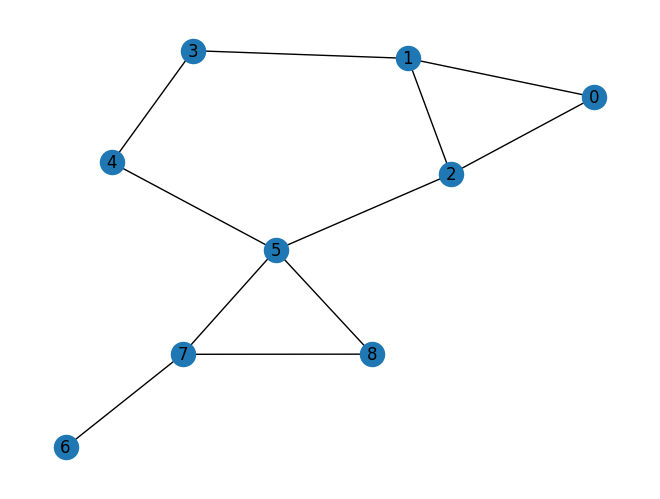

In [23]:
nx.draw_kamada_kawai(G,with_labels = True)
pos = nx.kamada_kawai_layout(G)

The following function deletes random edges, and adds additional random edges to a given graph

In [24]:
import random
import itertools
import networkx as nx

def perturb_graph_edges(G, k: int, m: int, seed: int = None) -> nx.Graph:
    """
    Return a copy of G with k random edges removed and m random non‐existing edges added.

    Parameters
    ----------
    G : networkx.Graph
        The original graph (undirected).
    k : int
        Number of edges to remove. If k > |E(G)|, all edges will be removed.
    m : int
        Number of edges to add. If m > number of possible new edges, as many as possible are added.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    G_new : networkx.Graph
        A new graph with k edges removed and m edges added.
    """
    if seed is not None:
        random.seed(seed)

    # Work on a copy
    G_new = G.copy()

    # 1) Remove k random edges
    existing_edges = list(G_new.edges())
    k_remove = min(k, len(existing_edges))
    edges_to_remove = random.sample(existing_edges, k_remove)
    G_new.remove_edges_from(edges_to_remove)

    # 2) Build list of all possible new edges (undirected, no self‐loops)
    nodes = list(G_new.nodes())
    existing = set(map(lambda e: tuple(sorted(e)), G_new.edges()))
    all_pairs = itertools.combinations(nodes, 2)
    possible_new = [pair for pair in all_pairs if pair not in existing]

    # 3) Add m random new edges
    m_add = min(m, len(possible_new))
    edges_to_add = random.sample(possible_new, m_add)
    G_new.add_edges_from(edges_to_add)

    return G_new


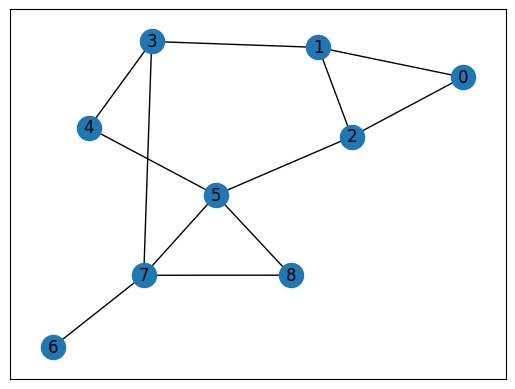

In [25]:
G_new = perturb_graph_edges(G,0,1)
nx.draw_networkx(G_new,pos = pos)

In [27]:
kernel = 'adjacency'

n = 10
n0 = n
n1 = n

S0 = []
S1 = []
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))

nu0 = ot.unif(n0)
nu1 = ot.unif(n1)

num_del0 = 1
num_add0 = 2

num_del1 = 0
num_add1 = 2

if kernel == 'distance':
    for j in range(n0):
        connected_flag = False
        while connected_flag == False:
            G_new = perturb_graph_edges(G,num_del0,num_add0)
            connected_flag = True
            if connected_flag:
                S0.append(nx.floyd_warshall_numpy(G_new))

    for j in range(n1):
        connected_flag = False
        while connected_flag == False:
            G_new = perturb_graph_edges(G,num_del1,num_add1)
            connected_flag = nx.is_connected(G_new)
            if connected_flag:
                S1.append(nx.floyd_warshall_numpy(G_new))

if kernel == 'adjacency':
    for j in range(n0):
        G_new = perturb_graph_edges(G,num_del0,num_add0)
        S0.append(nx.to_numpy_array(G_new))

    for j in range(n1):
        G_new = perturb_graph_edges(G,num_del1,num_add1)
        S1.append(nx.to_numpy_array(G_new))

In [29]:
T_best, log = gromov_wasserstein(
    S0[1], S1[1],
    p=mu0, q=mu1,
    loss_fun="square_loss",
    random_init=True,
    random_seed=42,
    random_init_iter=5,
    multiple_random_inits=5,
    log=True,
    max_iter=200,
    tol_rel=1e-6,
)

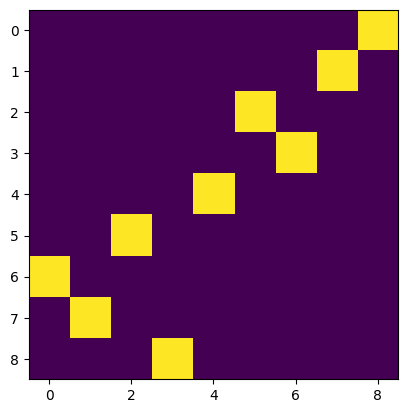

In [30]:
plt.imshow(T_best)

In [31]:
log

{'loss': [0.4288403365426895,
  0.41438398247937647,
  0.32098754223085774,
  0.26954721301275075,
  0.22222211013209234,
  0.2191356903790059,
  0.1728393940827096,
  0.1728393940827096],
 'cost': 0.345679012345679,
 'u': array([ 2.22222222e-01,  1.38777878e-15,  2.22222222e-01,  2.22222222e-01,
         2.22222222e-01,  2.22222222e-01,  2.22222222e-01, -1.66533454e-16,
         2.22222222e-01]),
 'v': array([ 2.22222222e-01,  4.44444444e-01,  2.22222222e-01,  1.66533454e-16,
         4.44444444e-01,  4.44444444e-01,  1.66533454e-16, -1.38777878e-15,
        -2.22222222e-01]),
 'warning': None,
 'result_code': 1,
 'gw_dist': 0.1728393940827096}

In [32]:
log['gw_dist']

0.1728393940827096

In [33]:
G, Q, cost = gromov_wasserstein_on_sets(
    S0, S1, mu0, mu1,
    multiple_random_inits=5,
    random_seed=0,
    verbose=False
)

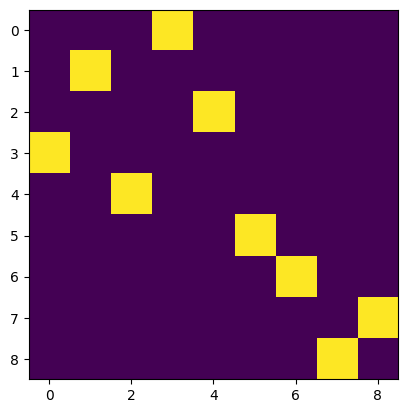

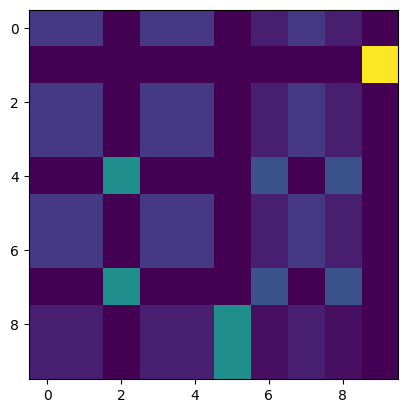

In [34]:
plt.imshow(G)
plt.show()
plt.imshow(Q)
plt.show()

# Real Experiment

This will iterate on the above idea, with the goal of producing a paper-ready experiment.

Idea: for given numbers of deletions and additions (which we will vary in the experiment), we:
- create two datasets of n graphs, for n = 1, 10, 20, 50, 100
- compute multiscale GW distance
- compute pairwise (standard) GW distances and average the result
- run the above 10 times and average the results

In [35]:
G = nx.Graph()
G.add_nodes_from(list(range(9)))
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,5),(3,4),(4,5),(5,7),(5,8),(6,7),(7,8)])

In [36]:
kernel = 'adjacency'
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1,10,20,50,100]
num_random_inits = 20

################################

num_del_add = 2

num_del0 = num_del_add
num_add0 = num_del_add

num_del1 = num_del_add
num_add1 = num_del_add

scores_multiscale = []
scores_gw = []

###############################

for n in ns:


    n0 = n
    n1 = n

    ###############################

    trial_scores_multiscale = []
    trial_scores_gw = []

    for ii in range(num_trials):

        S0 = []
        S1 = []

        nu0 = ot.unif(n0)
        nu1 = ot.unif(n1)

        if kernel == 'distance':
            for j in range(n0):
                connected_flag = False
                while connected_flag == False:
                    G_new = perturb_graph_edges(G,num_del0,num_add0)
                    connected_flag = True
                    if connected_flag:
                        S0.append(nx.floyd_warshall_numpy(G_new))

            for j in range(n1):
                connected_flag = False
                while connected_flag == False:
                    G_new = perturb_graph_edges(G,num_del1,num_add1)
                    connected_flag = nx.is_connected(G_new)
                    if connected_flag:
                        S1.append(nx.floyd_warshall_numpy(G_new))

        if kernel == 'adjacency':
            for j in range(n0):
                G_new = perturb_graph_edges(G,num_del0,num_add0)
                S0.append(nx.to_numpy_array(G_new))

            for j in range(n1):
                G_new = perturb_graph_edges(G,num_del1,num_add1)
                S1.append(nx.to_numpy_array(G_new))

        T, Q, cost = gromov_wasserstein_on_sets(
            S0, S1, mu0, mu1,
            multiple_random_inits=num_random_inits,
            random_seed=0,
            verbose=False
        )


        trial_scores_gw_trial = []

        for jj in range(n):
            T_best, log = gromov_wasserstein(
                S0[jj], S1[jj],
                p=mu0, q=mu1,
                loss_fun="square_loss",
                random_init=True,
                random_seed=42,
                random_init_iter=5,
                multiple_random_inits=num_random_inits,
                log=True,
                max_iter=200,
                tol_rel=1e-6,
            )
            
            trial_scores_gw_trial.append(log['gw_dist'])

        trial_scores_gw.append(np.mean(trial_scores_gw_trial))
        trial_scores_multiscale.append(cost)

    scores_multiscale.append(trial_scores_multiscale)
    scores_gw.append(trial_scores_gw)
    print(n)
    

1
10
20


KeyboardInterrupt: 

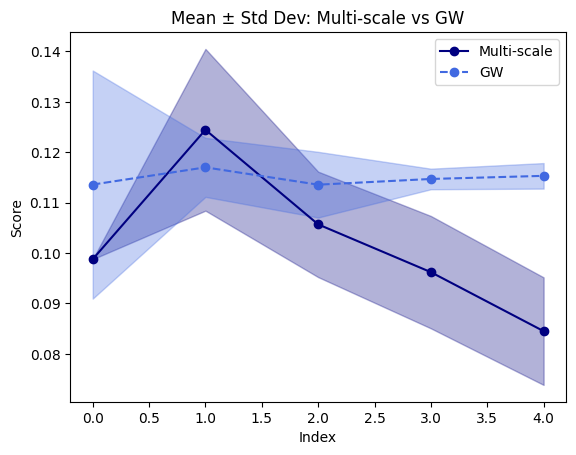

In [384]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these example lists with your actual data
# scores_multiscale = [...]
# scores_gw = [...]

# Compute means and standard deviations
means_ms = np.array([np.mean(s) for s in scores_multiscale])
stds_ms  = np.array([np.std(s)  for s in scores_multiscale])
means_gw = np.array([np.mean(s) for s in scores_gw])
stds_gw  = np.array([np.std(s)  for s in scores_gw])

x = np.arange(len(means_ms))

# Define two similar but distinct colors
color1 = 'navy'
color2 = 'royalblue'

plt.figure()
# Multi-scale: solid line + shaded region
plt.plot(x, means_ms, 'o-', label='Multi-scale', color=color1)
plt.fill_between(x,
                 means_ms - stds_ms,
                 means_ms + stds_ms,
                 alpha=0.3,
                 color=color1)

# GW: dashed line + shaded region
plt.plot(x, means_gw, 'o--', label='GW', color=color2)
plt.fill_between(x,
                 means_gw - stds_gw,
                 means_gw + stds_gw,
                 alpha=0.3,
                 color=color2)

plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Mean ± Std Dev: Multi-scale vs GW')
plt.legend()
plt.show()


In [386]:
kernel = 'adjacency'
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1,10,20,50,100]
num_random_inits = 10

################################

num_del_adds = [1,2,3]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:


        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == 'distance':
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del0,num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del1,num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == 'adjacency':
                for j in range(n0):
                    G_new = perturb_graph_edges(G,num_del0,num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G,num_del1,num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gromov_wasserstein_on_sets(
                S0, S1, mu0, mu1,
                multiple_random_inits=num_random_inits,
                random_seed=0,
                verbose=False
            )


            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, log = gromov_wasserstein(
                    S0[jj], S1[jj],
                    p=mu0, q=mu1,
                    loss_fun="square_loss",
                    random_init=True,
                    random_seed=42,
                    random_init_iter=5,
                    multiple_random_inits=num_random_inits,
                    log=True,
                    max_iter=200,
                    tol_rel=1e-6,
                )
                
                trial_scores_gw_trial.append(log['gw_dist'])

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print('n',n)
    
    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print('del_add',num_del_add)

n 1
n 10
n 20
n 50
n 100
del_add 1
n 1
n 10
n 20
n 50
n 100
del_add 2
n 1
n 10
n 20
n 50
n 100
del_add 3


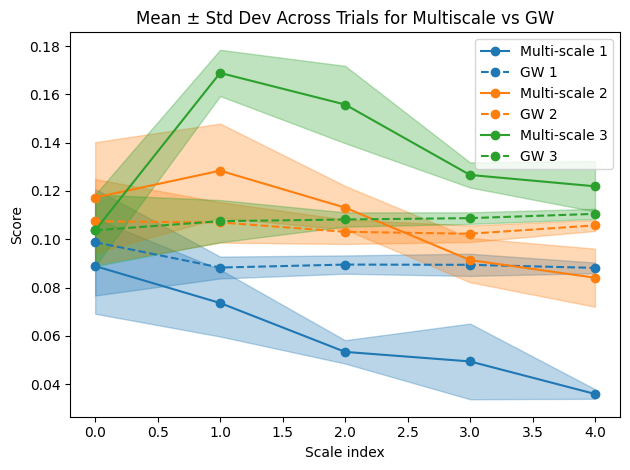

In [387]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual data:
# all_scores_multiscale = [trial_scores_multiscale1, trial_scores_multiscale2, trial_scores_multiscale3]
# all_scores_gw         = [trial_scores_gw1,         trial_scores_gw2,         trial_scores_gw3]

# Example placeholder data (remove/comment out in your actual code)
# all_scores_multiscale = [
#     [[0.1, 0.2, 0.15], [0.05, 0.07, 0.06], [0.2, 0.22, 0.19]],
#     [[0.11, 0.21, 0.16], [0.055, 0.075, 0.065], [0.21, 0.23, 0.18]],
#     [[0.12, 0.22, 0.14], [0.06, 0.08, 0.07], [0.19, 0.24, 0.2]]
# ]
# all_scores_gw = [
#     [[0.12, 0.18, 0.14], [0.06, 0.08, 0.07], [0.25, 0.23, 0.2]],
#     [[0.13, 0.19, 0.15], [0.065, 0.085, 0.075], [0.24, 0.22, 0.21]],
#     [[0.14, 0.2,  0.13], [0.07, 0.09, 0.08], [0.23, 0.21, 0.22]]
# ]

# Colormap for distinct colors
cmap = plt.get_cmap('tab10')
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure()
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms  = np.array([np.std(s)  for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw  = np.array([np.std(s)  for s in scores_gw])
    
    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, 'o-', color=color, label=f'Multi-scale {idx+1}')
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, 'o--', color=color, label=f'GW {idx+1}')
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel('Scale index')
plt.ylabel('Score')
plt.title('Mean ± Std Dev Across Trials for Multiscale vs GW')
plt.legend()
plt.tight_layout()
plt.show()


## Karate Club

Running the same experiment on the 'Karate Club' Graph. The hope is that, for a bigger graph, the benefits of the multiscale approach will be more pronounced.

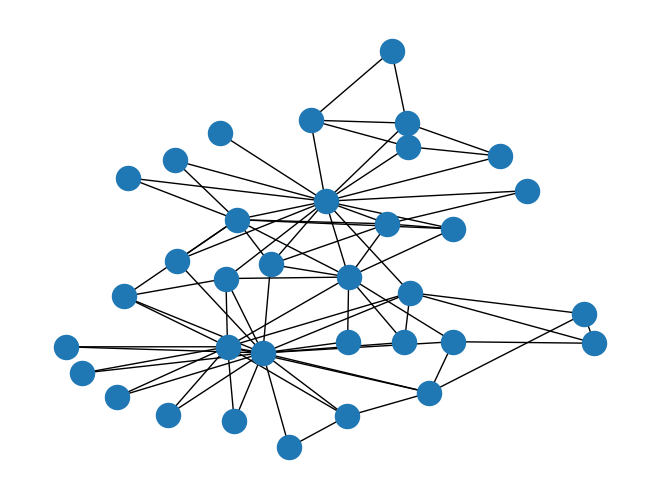

In [411]:
G_weighted = nx.karate_club_graph()
G = nx.Graph()
G.add_nodes_from(G_weighted.nodes())
G.add_edges_from(G_weighted.edges())
pos = nx.kamada_kawai_layout(G)
nx.draw_kamada_kawai(G)

In [412]:
kernel = 'adjacency'
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [1,10,20,50,100]
num_random_inits = 10

################################

num_del_adds = [1,2,3]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:


        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == 'distance':
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del0,num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del1,num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == 'adjacency':
                for j in range(n0):
                    G_new = perturb_graph_edges(G,num_del0,num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G,num_del1,num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gromov_wasserstein_on_sets(
                S0, S1, mu0, mu1,
                multiple_random_inits=num_random_inits,
                random_seed=0,
                verbose=False
            )


            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, log = gromov_wasserstein(
                    S0[jj], S1[jj],
                    p=mu0, q=mu1,
                    loss_fun="square_loss",
                    random_init=True,
                    random_seed=42,
                    random_init_iter=5,
                    multiple_random_inits=num_random_inits,
                    log=True,
                    max_iter=200,
                    tol_rel=1e-6,
                )
                
                trial_scores_gw_trial.append(log['gw_dist'])

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print('n',n)
    
    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print('del_add',num_del_add)

n 1
n 10
n 20
n 50
n 100
del_add 1
n 1
n 10
n 20
n 50
n 100
del_add 2
n 1
n 10
n 20
n 50
n 100
del_add 3


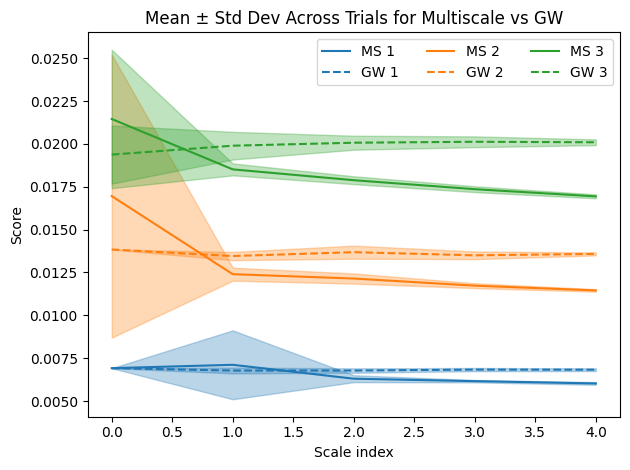

In [416]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual data:
# all_scores_multiscale = [trial_scores_multiscale1, trial_scores_multiscale2, trial_scores_multiscale3]
# all_scores_gw         = [trial_scores_gw1,         trial_scores_gw2,         trial_scores_gw3]

# Example placeholder data (remove/comment out in your actual code)
# all_scores_multiscale = [
#     [[0.1, 0.2, 0.15], [0.05, 0.07, 0.06], [0.2, 0.22, 0.19]],
#     [[0.11, 0.21, 0.16], [0.055, 0.075, 0.065], [0.21, 0.23, 0.18]],
#     [[0.12, 0.22, 0.14], [0.06, 0.08, 0.07], [0.19, 0.24, 0.2]]
# ]
# all_scores_gw = [
#     [[0.12, 0.18, 0.14], [0.06, 0.08, 0.07], [0.25, 0.23, 0.2]],
#     [[0.13, 0.19, 0.15], [0.065, 0.085, 0.075], [0.24, 0.22, 0.21]],
#     [[0.14, 0.2,  0.13], [0.07, 0.09, 0.08], [0.23, 0.21, 0.22]]
# ]

# Colormap for distinct colors
cmap = plt.get_cmap('tab10')
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure()
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms  = np.array([np.std(s)  for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw  = np.array([np.std(s)  for s in scores_gw])
    
    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, '-', color=color, label=f'MS {idx+1}')
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, '--', color=color, label=f'GW {idx+1}')
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel('Scale index')
plt.ylabel('Score')
plt.title('Mean ± Std Dev Across Trials for Multiscale vs GW')
plt.legend(ncol = 3)
plt.tight_layout()
plt.show()


In [424]:
kernel = 'adjacency'
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [10,20,50,100,150]
num_random_inits = 20

################################

num_del_adds = [1,2,3,4,5]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:


        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == 'distance':
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del0,num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del1,num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == 'adjacency':
                for j in range(n0):
                    G_new = perturb_graph_edges(G,num_del0,num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G,num_del1,num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gromov_wasserstein_on_sets(
                S0, S1, mu0, mu1,
                multiple_random_inits=num_random_inits,
                random_seed=0,
                verbose=False
            )


            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, log = gromov_wasserstein(
                    S0[jj], S1[jj],
                    p=mu0, q=mu1,
                    loss_fun="square_loss",
                    random_init=True,
                    random_seed=42,
                    random_init_iter=5,
                    multiple_random_inits=num_random_inits,
                    log=True,
                    max_iter=200,
                    tol_rel=1e-6,
                )
                
                trial_scores_gw_trial.append(log['gw_dist'])

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print('n',n)
    
    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print('del_add',num_del_add)

n 10
n 20
n 50
n 100
n 150
del_add 1
n 10
n 20
n 50
n 100
n 150
del_add 2
n 10
n 20
n 50
n 100
n 150
del_add 3
n 10
n 20
n 50
n 100
n 150
del_add 4
n 10
n 20
n 50
n 100
n 150
del_add 5


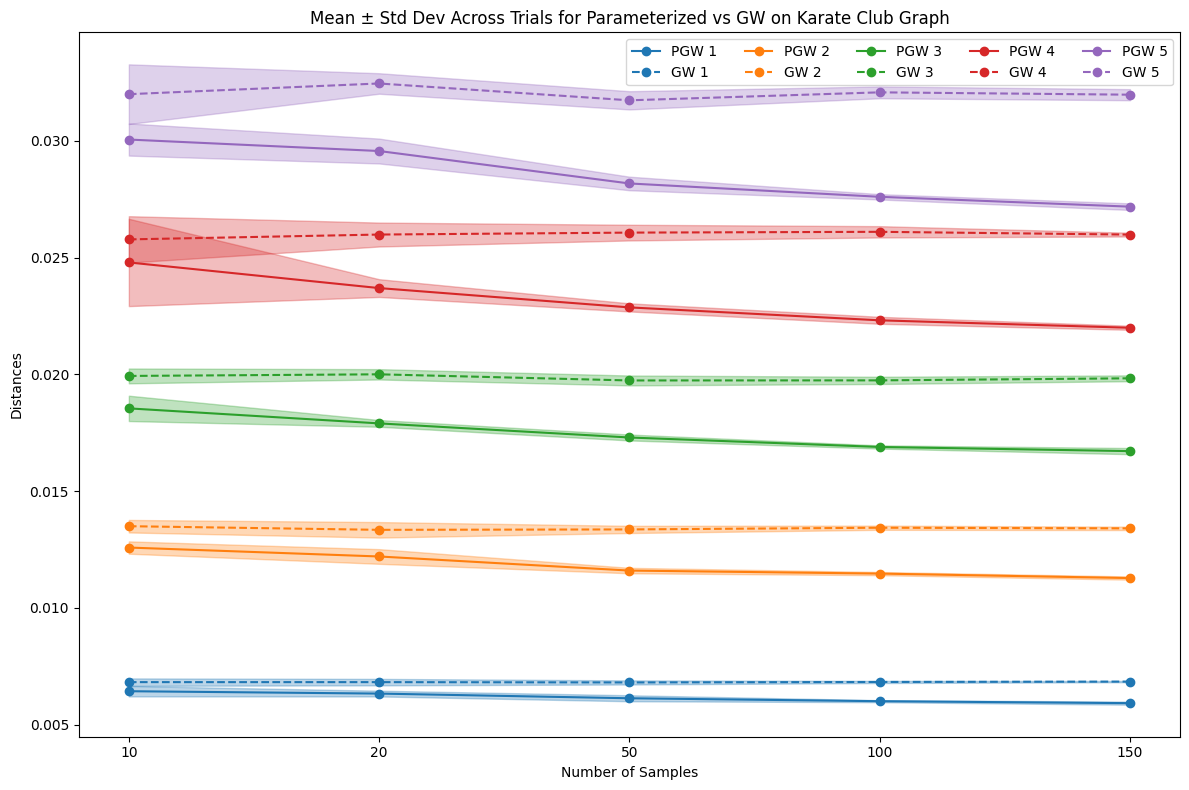

In [434]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with your actual data:
# all_scores_multiscale = [trial_scores_multiscale1, trial_scores_multiscale2, trial_scores_multiscale3]
# all_scores_gw         = [trial_scores_gw1,         trial_scores_gw2,         trial_scores_gw3]

# Example placeholder data (remove/comment out in your actual code)
# all_scores_multiscale = [
#     [[0.1, 0.2, 0.15], [0.05, 0.07, 0.06], [0.2, 0.22, 0.19]],
#     [[0.11, 0.21, 0.16], [0.055, 0.075, 0.065], [0.21, 0.23, 0.18]],
#     [[0.12, 0.22, 0.14], [0.06, 0.08, 0.07], [0.19, 0.24, 0.2]]
# ]
# all_scores_gw = [
#     [[0.12, 0.18, 0.14], [0.06, 0.08, 0.07], [0.25, 0.23, 0.2]],
#     [[0.13, 0.19, 0.15], [0.065, 0.085, 0.075], [0.24, 0.22, 0.21]],
#     [[0.14, 0.2,  0.13], [0.07, 0.09, 0.08], [0.23, 0.21, 0.22]]
# ]

# Colormap for distinct colors
cmap = plt.get_cmap('tab10')
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]

x = np.arange(len(all_scores_multiscale[0]))

plt.figure(figsize=(12,8))
for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute statistics
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms  = np.array([np.std(s)  for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw  = np.array([np.std(s)  for s in scores_gw])
    
    color = colors[idx]
    # Multi-scale: solid
    plt.plot(x, means_ms, 'o-', color=color, label=f'PGW {idx+1}')
    plt.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed
    plt.plot(x, means_gw, 'o--', color=color, label=f'GW {idx+1}')
    plt.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

plt.xlabel('Number of Samples')
plt.xticks(x, [10, 20, 50, 100, 150])
plt.ylabel('Distances')
plt.title('Mean ± Std Dev Across Trials for Parameterized vs GW on Karate Club Graph')
plt.legend(ncol = 5)
plt.tight_layout()
plt.savefig('KarateClubGraph.png', dpi=300)
plt.show()




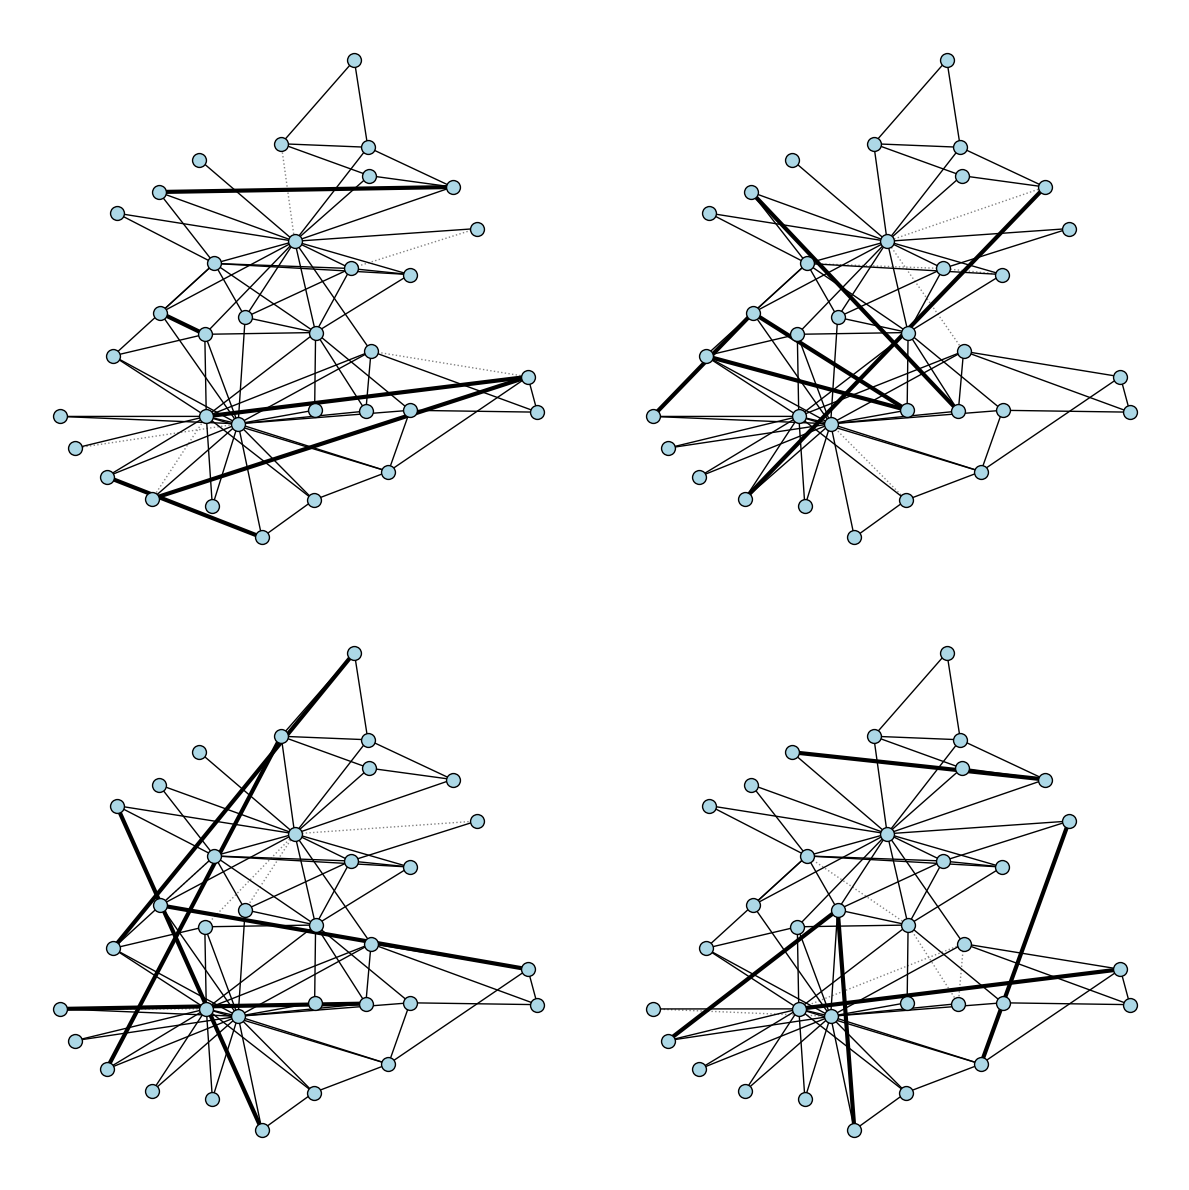

In [436]:
import matplotlib.pyplot as plt
import networkx as nx

# --- Preconditions: you must have G and pos already defined, and perturb_graph_edges imported ---

# Example:
# G = nx.erdos_renyi_graph(20, 0.2, seed=42)
# pos = nx.kamada_kawai_layout(G)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
seeds = [0, 1, 2, 3]  # for reproducibility

for idx, seed in enumerate(seeds):
    ax = axes[idx]
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)

    # Original and new edge sets (undirected, sorted tuples)
    orig_edges = {tuple(sorted(e)) for e in G.edges()}
    new_edges  = {tuple(sorted(e)) for e in Gi.edges()}

    deleted = list(orig_edges - new_edges)
    added   = list(new_edges - orig_edges)
    common  = list(orig_edges & new_edges)

    # 1) Plot deleted edges as dotted lines
    nx.draw_networkx_edges(
        G, pos,
        edgelist=deleted,
        style='dotted',
        edge_color='gray',
        ax=ax
    )

    # 2) Plot the edges that remain (common) as normal thin lines
    nx.draw_networkx_edges(
        Gi, pos,
        edgelist=common,
        edge_color='black',
        width=1,
        ax=ax
    )

    # 3) Plot added edges as thicker lines
    nx.draw_networkx_edges(
        Gi, pos,
        edgelist=added,
        edge_color='black',
        width=3,
        ax=ax
    )

    # 4) Draw nodes on top
    nx.draw_networkx_nodes(
        Gi, pos,
        node_size=100,
        node_color='lightblue',
        edgecolors='k',
        ax=ax
    )

    # ax.set_title(f'Perturbation {idx+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


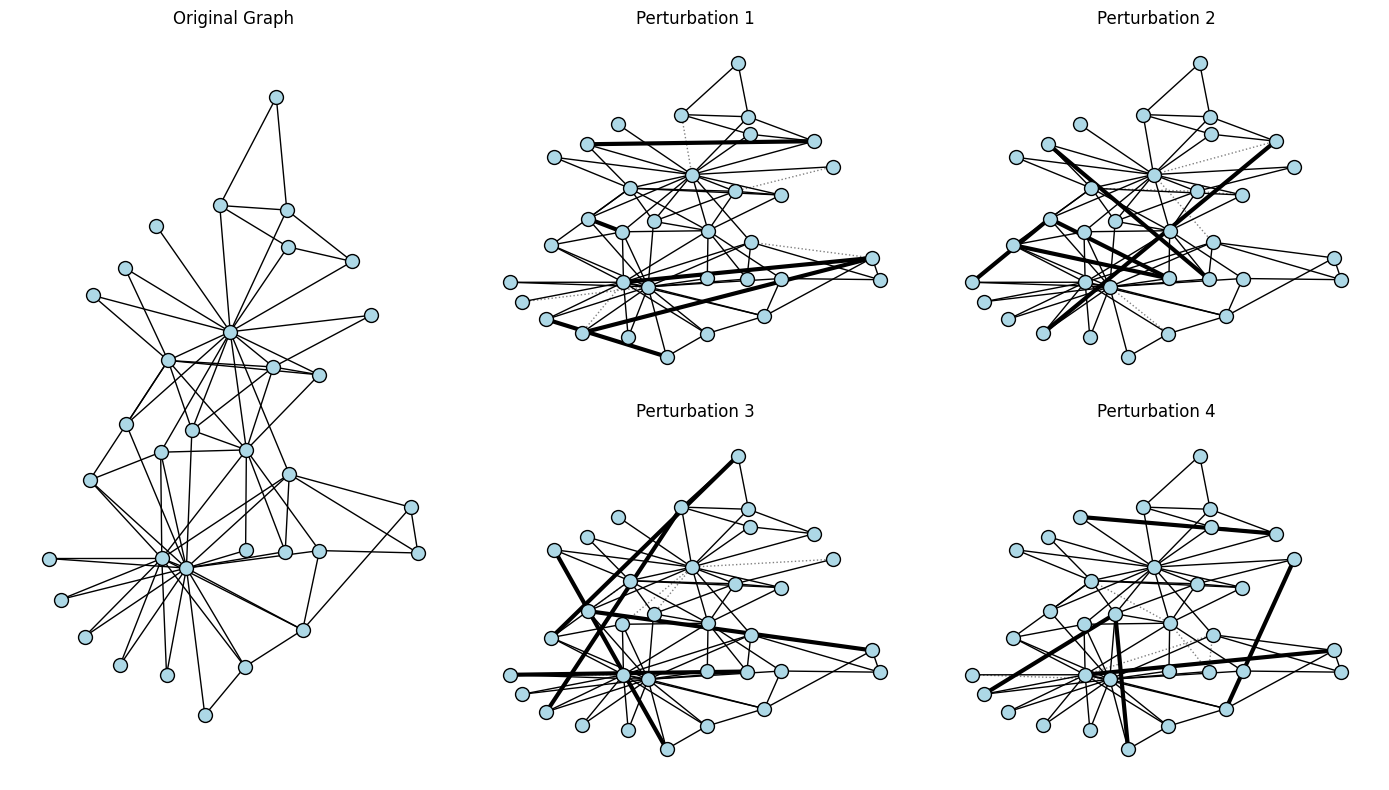

In [438]:
import matplotlib.pyplot as plt
import networkx as nx

# --- Preconditions: you must have G, pos, and perturb_graph_edges defined ---

# Create a figure with 2 rows x 3 columns, left column for original spanning both rows
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1])

# 1) Plot original graph on the left (spanning both rows)
ax_orig = fig.add_subplot(gs[:, 0])
orig_edges = list(G.edges())
nx.draw_networkx_edges(
    G, pos,
    edgelist=orig_edges,
    edge_color='black',
    width=1,
    ax=ax_orig
)
nx.draw_networkx_nodes(
    G, pos,
    node_size=100,
    node_color='lightblue',
    edgecolors='k',
    ax=ax_orig
)
ax_orig.set_title('Original Graph')
ax_orig.axis('off')

# 2) Generate and plot 4 perturbed versions
seeds = [0, 1, 2, 3]
for idx, seed in enumerate(seeds):
    ax = fig.add_subplot(gs[idx // 2, (idx % 2) + 1])
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)

    orig_set = {tuple(sorted(e)) for e in G.edges()}
    new_set = {tuple(sorted(e)) for e in Gi.edges()}

    deleted = list(orig_set - new_set)
    common  = list(orig_set & new_set)
    added   = list(new_set - orig_set)

    # Deleted edges: dotted gray
    nx.draw_networkx_edges(
        G, pos,
        edgelist=deleted,
        style='dotted',
        edge_color='gray',
        ax=ax
    )
    # Common edges: thin black
    nx.draw_networkx_edges(
        Gi, pos,
        edgelist=common,
        edge_color='black',
        width=1,
        ax=ax
    )
    # Added edges: thicker black
    nx.draw_networkx_edges(
        Gi, pos,
        edgelist=added,
        edge_color='black',
        width=3,
        ax=ax
    )
    # Nodes
    nx.draw_networkx_nodes(
        Gi, pos,
        node_size=100,
        node_color='lightblue',
        edgecolors='k',
        ax=ax
    )

    ax.set_title(f'Perturbation {idx + 1}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('RandomGraphModel_KarateClub.png',dpi=300)
plt.show()


/var/folders/5t/5kbjtfhd3zn048pmh419xnxr0000gp/T/ipykernel_79258/763114614.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


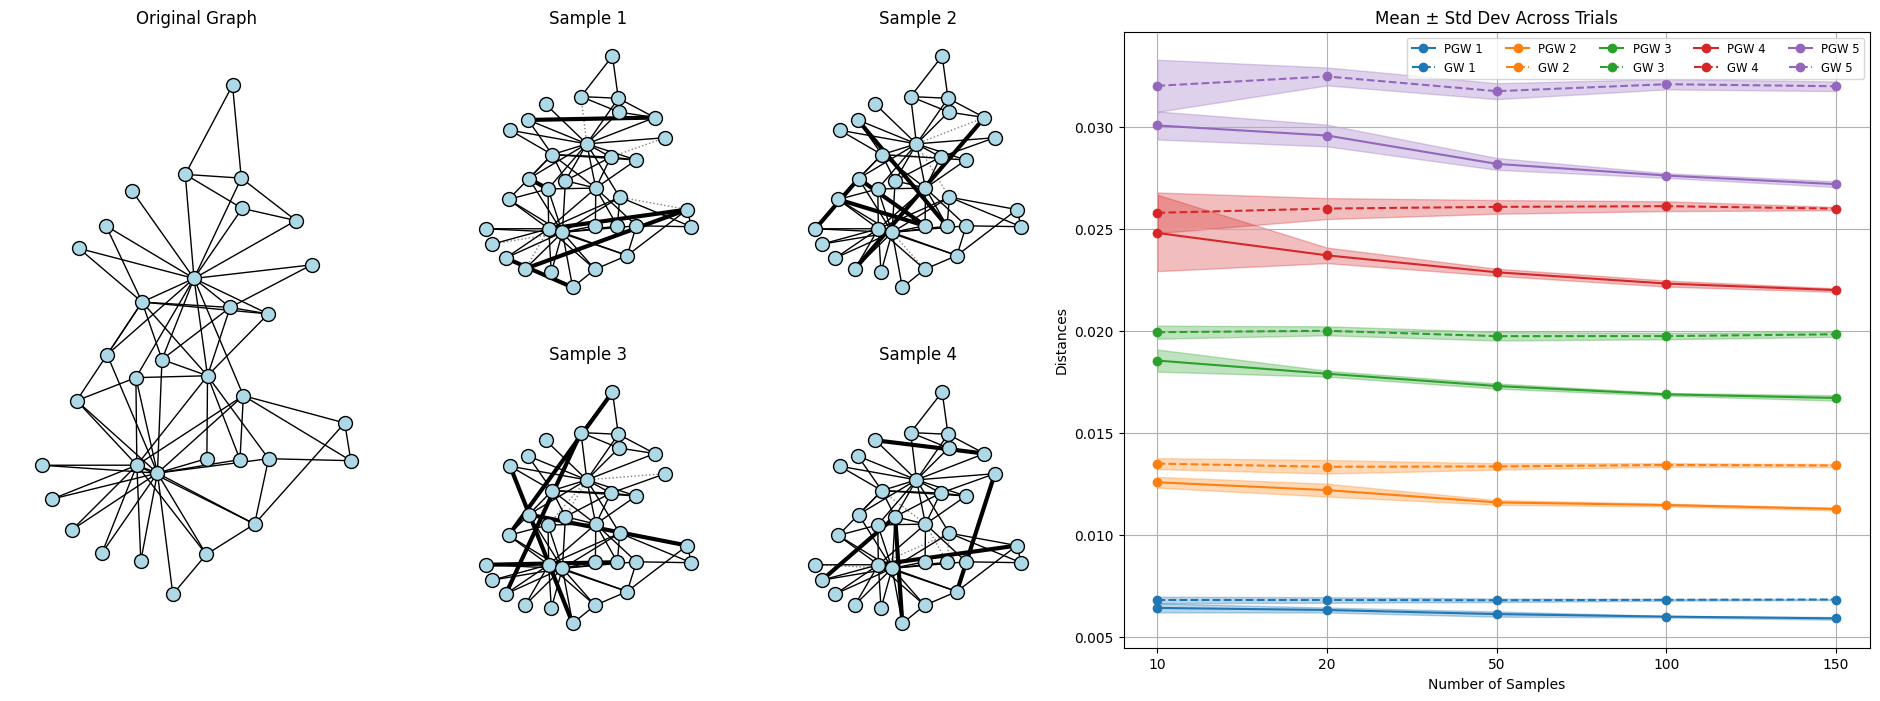

In [458]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Preconditions: You must have the following defined in the environment:
# G : networkx.Graph
# pos : dict mapping nodes to (x,y) positions (e.g., from kamada_kawai_layout)
# perturb_graph_edges : function defined as above
# all_scores_multiscale : list of lists of lists ([[[...],...], ...])
# all_scores_gw : list of lists of lists

# Example placeholders (comment out if you have real data defined):
# G = nx.erdos_renyi_graph(30, 0.2, seed=42)
# pos = nx.kamada_kawai_layout(G)
# all_scores_multiscale = [...] 
# all_scores_gw = [...]

# Create figure with 2 rows, 4 columns (last column for scores)
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(2, 4, width_ratios=[1.5, 1, 1, 3], wspace=0.2)

# 1) Original graph on left, spans both rows in column 0
ax0 = fig.add_subplot(gs[:, 0])
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), edge_color='black', width=1, ax=ax0)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', edgecolors='k', ax=ax0)
ax0.set_title('Original Graph')
ax0.axis('off')

# 2) Four perturbed graphs in columns 1 and 2
seeds = [0, 1, 2, 3]
for idx, seed in enumerate(seeds):
    row = idx // 2
    col = (idx % 2) + 1
    ax = fig.add_subplot(gs[row, col])
    Gi = perturb_graph_edges(G, k=5, m=5, seed=seed)
    
    orig_set = {tuple(sorted(e)) for e in G.edges()}
    new_set  = {tuple(sorted(e)) for e in Gi.edges()}
    deleted  = list(orig_set - new_set)
    common   = list(orig_set & new_set)
    added    = list(new_set - orig_set)
    
    # Deleted edges: dotted gray
    nx.draw_networkx_edges(G, pos, edgelist=deleted, style='dotted', edge_color='gray', ax=ax)
    # Common edges: thin black
    nx.draw_networkx_edges(Gi, pos, edgelist=common, edge_color='black', width=1, ax=ax)
    # Added edges: thick black
    nx.draw_networkx_edges(Gi, pos, edgelist=added, edge_color='black', width=3, ax=ax)
    # Nodes
    nx.draw_networkx_nodes(Gi, pos, node_size=100, node_color='lightblue', edgecolors='k', ax=ax)
    
    ax.set_title(f'Sample {idx+1}')
    ax.axis('off')

# 3) Scores plot in column 3 spanning both rows
ax_scores = fig.add_subplot(gs[:, 3])
cmap = plt.get_cmap('tab10')
n_plots = len(all_scores_multiscale)
colors = [cmap(i) for i in range(n_plots)]
x = np.arange(len(all_scores_multiscale[0]))

for idx, (scores_ms, scores_gw) in enumerate(zip(all_scores_multiscale, all_scores_gw)):
    # Compute mean and std
    means_ms = np.array([np.mean(s) for s in scores_ms])
    stds_ms  = np.array([np.std(s)  for s in scores_ms])
    means_gw = np.array([np.mean(s) for s in scores_gw])
    stds_gw  = np.array([np.std(s)  for s in scores_gw])
    
    color = colors[idx]
    # Multi-scale: solid + shaded
    ax_scores.plot(x, means_ms, 'o-', color=color, label=f'PGW {idx+1}')
    ax_scores.fill_between(x, means_ms - stds_ms, means_ms + stds_ms, alpha=0.3, color=color)
    # GW: dashed + shaded
    ax_scores.plot(x, means_gw, 'o--', color=color, label=f'GW {idx+1}')
    ax_scores.fill_between(x, means_gw - stds_gw, means_gw + stds_gw, alpha=0.3, color=color)

ax_scores.set_xlabel('Number of Samples')
ax_scores.set_xticks(x, [10, 20, 50, 100, 150])
ax_scores.set_ylabel('Distances')
ax_scores.set_title('Mean ± Std Dev Across Trials')
ax_scores.legend(ncol=n_plots, fontsize='small')
ax_scores.grid(True)

plt.tight_layout()
plt.savefig('SummaryFigure_KarateClub.png',dpi=300,bbox_inches="tight",   # crop to the figure’s contents
    pad_inches=0.1)
plt.show()


## Erdos-Renyi Graph Clustering Experiment

0
1
2
3
4
5
6
7
8
9
10
11
10


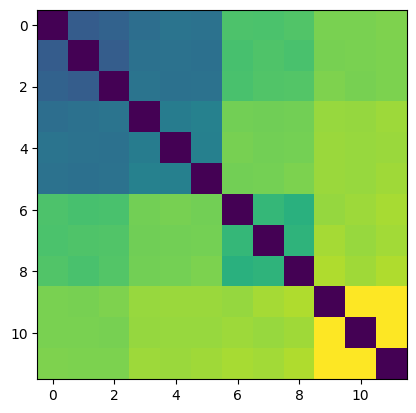

0
1
2
3
4
5
6
7
8
9
10
11
20


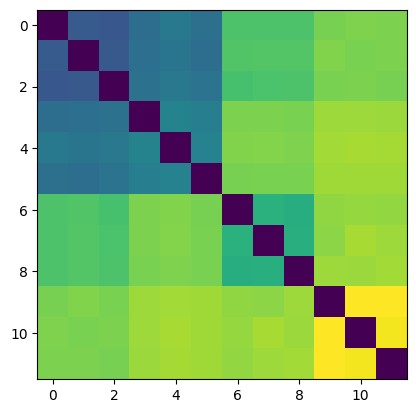

0
1
2
3
4
5
6
7
8
9
10
11
50


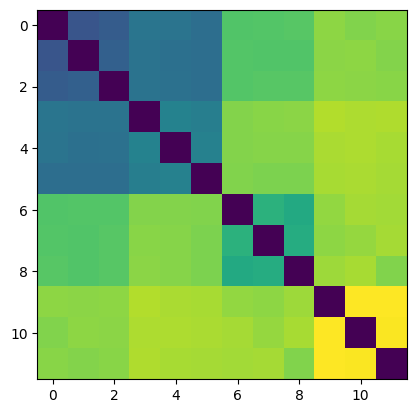

0
1
2
3
4
5
6
7
8
9
10
11
100


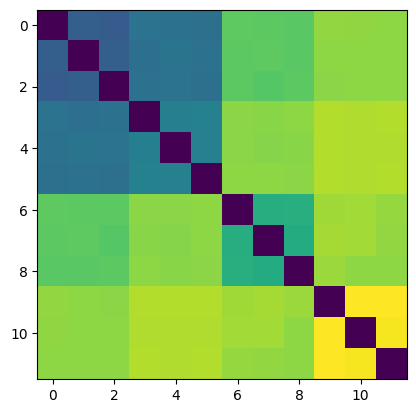

0
1
2
3
4
5
6
7
8
9
10
11
150


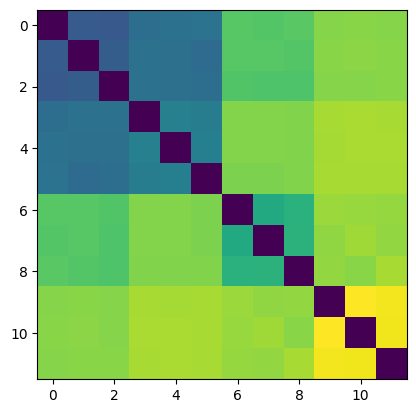

In [495]:
num_verts = [50,50,50,50]
ps = [.2,.4,.2,.4]
ks = [5,5,10,10]
num_copies = 3
num_random_inits = 20

mus0 = [ot.unif(v) for v in num_verts]
mus = [x for x in mus0 for _ in range(num_copies)]

all_dist_mats = []

for n in ns:

    dataset = []

    for ii in range(len(num_verts)):
        for kk in range(num_copies):
            S = []
            v = num_verts[ii]
            p = ps[ii]
            k = ks[ii]
            for jj in range(n):
                G = nx.watts_strogatz_graph(v,k,p)
                S.append(nx.to_numpy_array(G))

            dataset.append(S)

    dist_mat = np.zeros([len(dataset),len(dataset)])

    for ii in range(len(dataset)):
        S0 = dataset[ii]
        mu0 = mus[ii]
        for jj in range(ii+1,len(dataset)):
            S1 = dataset[jj]
            mu1 = mus[jj]
            T, Q, cost = gromov_wasserstein_on_sets(
                    S0, S1, mu0, mu1,
                    multiple_random_inits=num_random_inits,
                    random_seed=0,
                    verbose=False
                )
            dist_mat[ii,jj] = cost

        print(ii)

    dist_mat = dist_mat + dist_mat.T
    all_dist_mats.append(dist_mat)
    print(n)
    plt.imshow(dist_mat)
    plt.show()




In [496]:
all_dist_mats[4]

array([[0.        , 0.06525466, 0.06328606, 0.08244505, 0.08591176,
        0.08697017, 0.16849785, 0.16667761, 0.16944754, 0.18677718,
        0.18714066, 0.18690651],
       [0.06525466, 0.        , 0.06709904, 0.08477434, 0.08376908,
        0.08015115, 0.16879181, 0.16844347, 0.16728676, 0.18764257,
        0.18847454, 0.18736564],
       [0.06328606, 0.06709904, 0.        , 0.08608614, 0.08392469,
        0.08228115, 0.16646811, 0.16571972, 0.16567735, 0.18668485,
        0.18664751, 0.18789525],
       [0.08244505, 0.08477434, 0.08608614, 0.        , 0.09893015,
        0.09646312, 0.18606854, 0.18543177, 0.18513723, 0.19868667,
        0.19915223, 0.19826053],
       [0.08591176, 0.08376908, 0.08392469, 0.09893015, 0.        ,
        0.09831842, 0.18614197, 0.18612442, 0.1848293 , 0.19754326,
        0.1992094 , 0.19893015],
       [0.08697017, 0.08015115, 0.08228115, 0.09646312, 0.09831842,
        0.        , 0.18355526, 0.18318191, 0.18486643, 0.19864403,
        0.19830306,

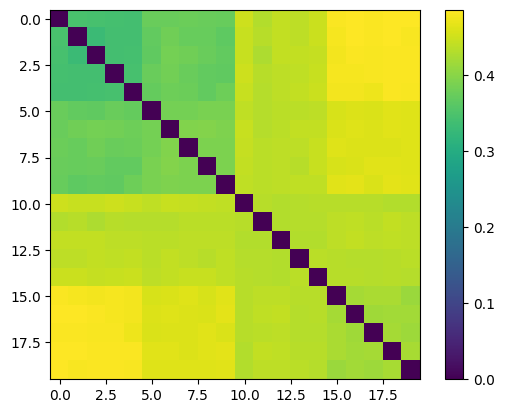

In [483]:
plt.imshow(dist_mat)
plt.colorbar()

In [ ]:
kernel = 'adjacency'
mu0 = ot.unif(len(G))
mu1 = ot.unif(len(G))
num_trials = 10
ns = [10,20,50,100,150]
num_random_inits = 20

################################

num_del_adds = [1,2,3,4,5]

all_scores_multiscale = []
all_scores_gw = []

for num_del_add in num_del_adds:

    num_del0 = num_del_add
    num_add0 = num_del_add

    num_del1 = num_del_add
    num_add1 = num_del_add

    scores_multiscale = []
    scores_gw = []

    ###############################

    for n in ns:


        n0 = n
        n1 = n

        ###############################

        trial_scores_multiscale = []
        trial_scores_gw = []

        for ii in range(num_trials):

            S0 = []
            S1 = []

            nu0 = ot.unif(n0)
            nu1 = ot.unif(n1)

            if kernel == 'distance':
                for j in range(n0):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del0,num_add0)
                        connected_flag = True
                        if connected_flag:
                            S0.append(nx.floyd_warshall_numpy(G_new))

                for j in range(n1):
                    connected_flag = False
                    while connected_flag == False:
                        G_new = perturb_graph_edges(G,num_del1,num_add1)
                        connected_flag = nx.is_connected(G_new)
                        if connected_flag:
                            S1.append(nx.floyd_warshall_numpy(G_new))

            if kernel == 'adjacency':
                for j in range(n0):
                    G_new = perturb_graph_edges(G,num_del0,num_add0)
                    S0.append(nx.to_numpy_array(G_new))

                for j in range(n1):
                    G_new = perturb_graph_edges(G,num_del1,num_add1)
                    S1.append(nx.to_numpy_array(G_new))

            T, Q, cost = gromov_wasserstein_on_sets(
                S0, S1, mu0, mu1,
                multiple_random_inits=num_random_inits,
                random_seed=0,
                verbose=False
            )


            trial_scores_gw_trial = []

            for jj in range(n):
                T_best, log = gromov_wasserstein(
                    S0[jj], S1[jj],
                    p=mu0, q=mu1,
                    loss_fun="square_loss",
                    random_init=True,
                    random_seed=42,
                    random_init_iter=5,
                    multiple_random_inits=num_random_inits,
                    log=True,b
                    max_iter=200,
                    tol_rel=1e-6,
                )
                
                trial_scores_gw_trial.append(log['gw_dist'])

            trial_scores_gw.append(np.mean(trial_scores_gw_trial))
            trial_scores_multiscale.append(cost)

        scores_multiscale.append(trial_scores_multiscale)
        scores_gw.append(trial_scores_gw)
        print('n',n)
    
    all_scores_multiscale.append(scores_multiscale)
    all_scores_gw.append(scores_gw)

    print('del_add',num_del_add)